Необходимо построить posterior predictive distribution для эксперимента с подбрасываем монеты.

In [1]:
import pymc as pm
import numpy as np
import seaborn as sns

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Для генерации исходных данных о подбрасываниях монеты зададим число бросков и вероятность выпадения орла. Пусть монета будет честной с вероятностью выпадения орла 0,5.

In [2]:
num_flips = 20
theta_init = 0.5

Сгенерируем исходные данные с бросками.

In [3]:
data = np.random.binomial(1, theta_init, size=num_flips)

Частота выпадения орла в исходных данных.

In [4]:
data.mean()

0.55

Гистограмма с частотой выпадения решки и орла в исходных данных.

<Axes: ylabel='Probability'>

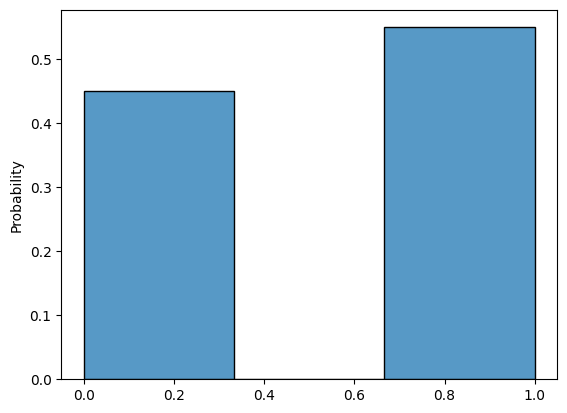

In [5]:
sns.histplot(data, stat='probability', bins=3)

Построим модель МСМС и сохраним трассировку (100 значений рассчитанной вероятности выпадения орла).

In [6]:
with pm.Model() as my_first_model:
  θ = pm.Beta('θ', alpha=1., beta=1.)
  y = pm.Bernoulli('y', p=θ, observed=data)
  trace = pm.sample(100, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Сгенерируем апостериорный прогноз.

In [7]:
ppc = pm.sample_posterior_predictive(trace, model=my_first_model, random_seed=2,
                                     )

Sampling: [y]


Output()

Объединим спрогнозированные результаты бросков по всем цепочкам и значениям трассировки (рассчитанным значениям вероятности выпадения орла).

In [8]:
new_data = ppc.posterior_predictive.stack(sample=["chain", "draw", "y_dim_2"]).y

In [9]:
new_data

<xarray.DataArray 'y' (sample: 8000)> Size: 64kB
array([1, 0, 0, ..., 1, 0, 1], dtype=int64)
Coordinates:
  * sample   (sample) object 64kB MultiIndex
  * chain    (sample) int32 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 32kB 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99
  * y_dim_2  (sample) int32 32kB 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19

Частота выпадения орла в posterior predictive.

In [10]:
new_data.mean()

<xarray.DataArray 'y' ()> Size: 8B
array(0.560375)

Гистограмма для posterior predictive.

<Axes: ylabel='Probability'>

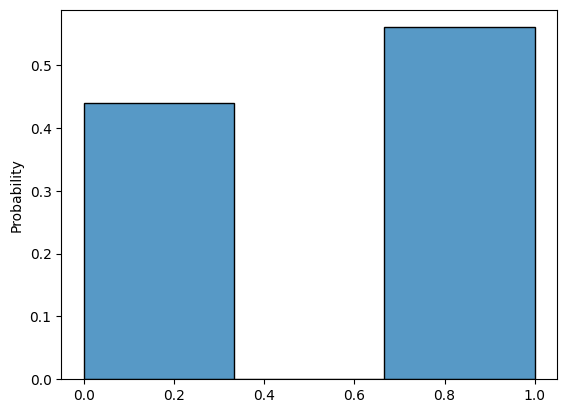

In [11]:
sns.histplot(new_data, stat='probability', bins=3)